# Tutorial 3 - Neural networks
***

In this tutorial, we will take a closer look at (popular) activation functions and investigate their effect on optimization properties in neural networks. 

Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks. There is a great variety of activation functions in the literature, and some are more beneficial than others. 

The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don’t.

***
### Importing libraries, downloading FashionMNIST dataset and some utils

In [1]:
# Import the necessary libraries
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import FashionMNIST   
from torchvision import transforms

# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')

TRAINED_MODELS_PATH = 'trained_models/'

In the cell below we are going to download the FashioMNIST dataset, formed of grey-scale images

Done!


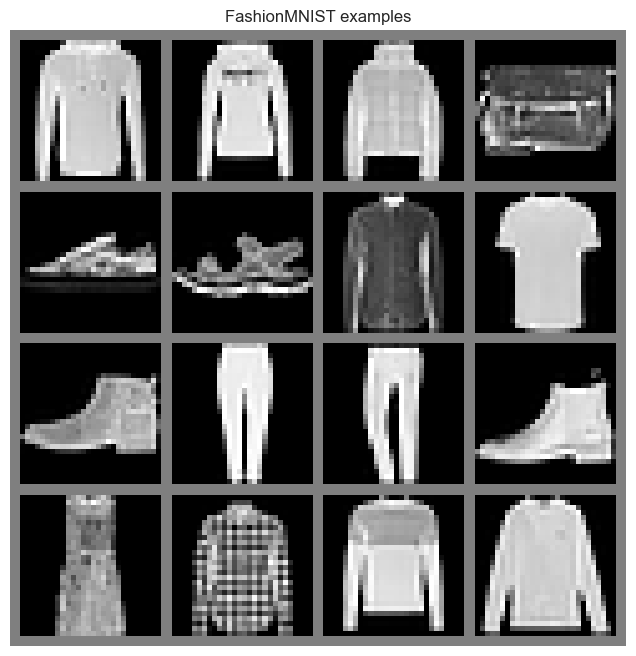

torch.Size([60000, 28, 28])

In [2]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="./", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root="./",train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader  = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader    = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader   = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

print('Done!')

# Let's visualize some of the images in the dataset
example_img = [train_set[i][0] for i in range(16)]

# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(example_img, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()
train_dataset.train_data.shape

## Common activation functions
***

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the torch.nn package (see the documentation for an overview). 
However, we’ll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [3]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the “oldest” activation functions that are still commonly used for various tasks: sigmoid and tanh. Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 

Here, we implement them by hand (using `torch.exp`), given that: 

1. Sigmoid:

    $$
    \sigma(x) = \frac{1}{1 + e^{-x}}
    $$

2. Tanh:

    $$
    \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
    $$

In [5]:
class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

###############################################################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)


Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values. Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish. LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input. Similarly, ELU replaces the negative part with an exponential decay. The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the “optimal” activation function. Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient). This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks.

Now implement the following activation functions without using torch.nn API

3. ReLU (Rectified Linear Unit):

    $$
    \text{ReLU}(x) = \max(0, x)
    $$

4. LeakyReLU (Leaky Rectified Linear Unit):

    $$
    \text{LeakyReLU}(x) = \begin{cases}
    x, & \text{if } x > 0 \\
    \alpha \cdot x, & \text{otherwise}
    \end{cases}
    $$
    where $\alpha$ is a small positive constant.

5. ELU (Exponential Linear Unit):

    $$
    \text{ELU}(x) = \begin{cases}
    x, & \text{if } x > 0 \\
    e^x - 1, & \text{otherwise}
    \end{cases}
    $$

6. Swish:

    $$
    \text{Swish}(x) = x \cdot \sigma(x)
    $$


In [6]:
class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

###############################################################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

###############################################################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

###############################################################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)
    
###############################################################
    
activation_by_name = {"sigmoid"  : Sigmoid,
                      "tanh"     : Tanh,
                      "relu"     : ReLU,
                      "leakyrelu": LeakyReLU,
                      "elu"      : ELU,
                      "swish"    : Swish}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following. Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. PyTorch allows us to compute the gradients simply by calling the `backward` function:

In [7]:
def get_gradients(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """

    # Mark the input as tensor for which we want to store gradients
    x = x.clone().requires_grad_()   

    # Forward pass through the activation function
    out = act_fn(x)

    # Summing results in an equal gradient flow to each element in x
    out.sum().backward()             

    # Accessing the gradients of x by "x.grad"
    return x.grad                    

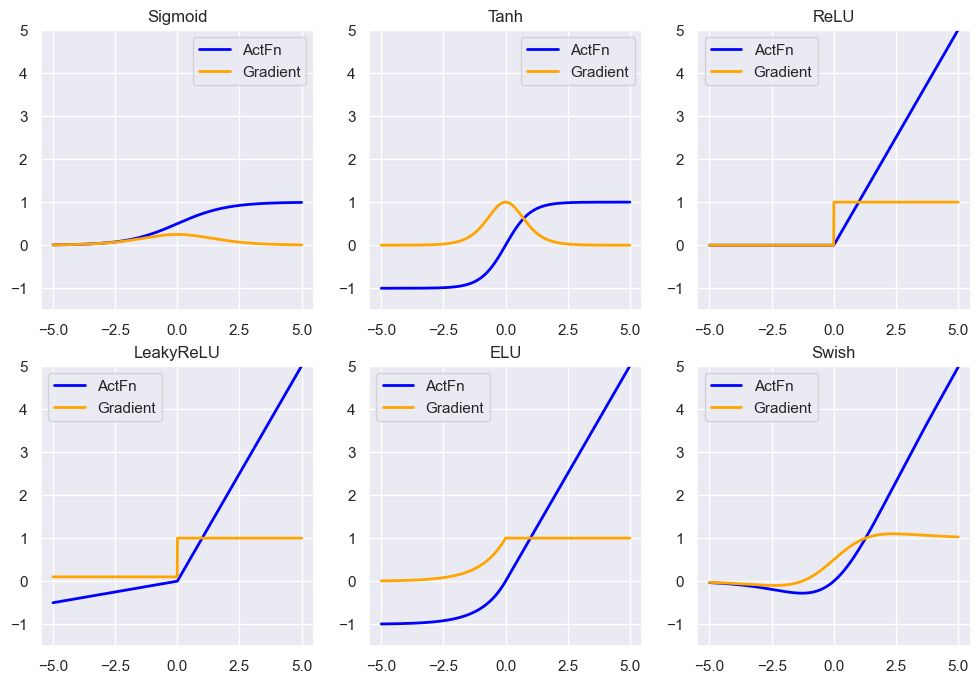

In [8]:
def visualize_activation_and_gradients(act_fn, ax, x):

    # Run activation function
    y = act_fn(x)
    y_grads = get_gradients(act_fn, x)

    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn", color='blue')
    ax.plot(x, y_grads, linewidth=2, label="Gradient", color='orange')
    ax.grid(True)
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Creating activation functions in a list by initializing them
act_fns = [act_fn() for act_fn in activation_by_name.values()]

# Range on which we want to visualize the activation function
x = torch.linspace(-5, 5, 1000) 

## Plotting
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()

for i, act_fn in enumerate(act_fns):
    visualize_activation_and_gradients(act_fn, ax[i], x)

plt.show()


## MyFirstDenseNet - Analysing ReLU approximation power
***

Dense layers, also known as fully connected (FC) layers, are a fundamental building block of many neural network architectures. They are characterized by having every neuron in one layer connected to every neuron in the next layer. This dense connectivity pattern is where they get their name. Dense layers are versatile and can be used in a wide range of applications, from simple linear regression models to complex deep learning networks.

A dense layer consists of a set of neurons, where each neuron receives input from all the neurons of the previous layer. The output of each neuron is computed as a weighted sum of these inputs, plus a bias term. The formula for the output of a neuron $i$ in a dense layer can be expressed as:

$$
y_i = \sum_j w_{ij}x_j + b_i
$$

where:

- $y_i$ is the output of neuron $i$,

- $x_j$ are the inputs from the previous layer or the input dataset,

- $w_{ij}$ are the weights associated with the connection between input $j$ and neuron $i$

- $b_i$ is the bias term for neuron $i$

In [9]:
class DenseLayer(nn.Module):

    """
    Implementation of a dense layer (also called a fully connected layer). 
    """

    def __init__(self, in_features, out_features, bias=True):

        super(DenseLayer, self).__init__()
        
        # Define the weights and biases of the layer as parameters (automatically sets requires_grad=True)
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        # Initialize the parameters (weights and biases) 
        self.reset_parameters()


    def reset_parameters(self):
        """
        Initialize the weights and biases of the layer. Kaiming uniform initialization is used. Google it for more details.
        """
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        """
        The forward pass of the dense layer.
        """

        return torch.matmul(input, self.weight.t()) + self.bias

In machine learning and deep learning, a loss function quantifies the difference between the predicted outputs of a model and the actual target values. It is a critical component that guides the training process. Two commonly used loss functions are Mean Squared Error (MSE) for regression tasks and Cross-Entropy Loss for classification tasks.

**Mean Squared Error (MSE) Loss**

Mean Squared Error (MSE) is a popular loss function used primarily in regression tasks. It calculates the average squared difference between the actual and predicted values. The formula for MSE is given by:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2
$$

where:


- $n$ is the number of samples,

- $y_i$ is the actual value of the $i$-th sample,

- $\hat{y_i}$ is the predicted value for the $i$-th sample.

MSE loss is advantageous because it penalizes larger errors more severely than smaller ones, encouraging the model to avoid significant mistakes. However, its sensitivity to outliers can sometimes be a drawback.

**Cross-Entropy Loss**

Cross-Entropy Loss measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. It is defined as:

The formula for categorical cross-entropy loss is:

$$
\text{{Categorical Cross-Entropy Loss}} = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$ 

where:

- $n$ is the number of samples,

- $C$ is the number of classes,

- $y_{ij}$ is the actual label (0 or 1) for the $i$-th sample and $j$-th class,

- $\hat{y}_{ij}$ is the predicted probability (between 0 and 1) for the $i$-th sample and $j$-th class.

For binary classification problem the formula reduces to:

$$
\text{{Cross-Entropy Loss}} = -\frac{1}{n}\sum_{i=1}^{n} \left(y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\right) 
$$

where:

- $n$ is the number of samples,

- $y_i$ is the actual label (0 or 1) of the $i$-th sample,


- $\hat{y}_i$ is the predicted probability (between 0 and 1) for the $i$-th sample.


Below we are going to implement the MSELoss (without using `nn.MSELoss()`)

In [10]:
class MyMSELoss(nn.Module):

    """ 
    Implementation of the mean squared error loss.
    """

    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        loss = torch.mean((input - target) ** 2)
        return loss

There are several different ways to implement a neural network in Pytorch. The first one 

In [11]:
class MyFirstDenseNet(nn.Module):

    """This is a way to define a network in PyTorch. We use the nn.Module class and define the forward pass ourselves."""

    def __init__(self, act_fn, input_size=784, output_size=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()

        # Initialize input layer
        self.input_layer = DenseLayer(input_size, hidden_sizes[0])

        # Initialize hidden layers in a list using a comprehension 
        self.hidden_layers = nn.ModuleList([DenseLayer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])

        # Initialize output layer
        self.output_layer = DenseLayer(hidden_sizes[-1], output_size)

        # Store the activation function
        self.act_fn = act_fn

    def forward(self, x):

        # Reshape images to a flat vector
        x = x.view(x.size(0), -1) 

        # Pass through input layer and activation function
        x = self.input_layer(x)
        x = self.act_fn(x)

        # Pass through hidden layers and activation function
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act_fn(x)

        # Pass through output layer
        x = self.output_layer(x)

        return x

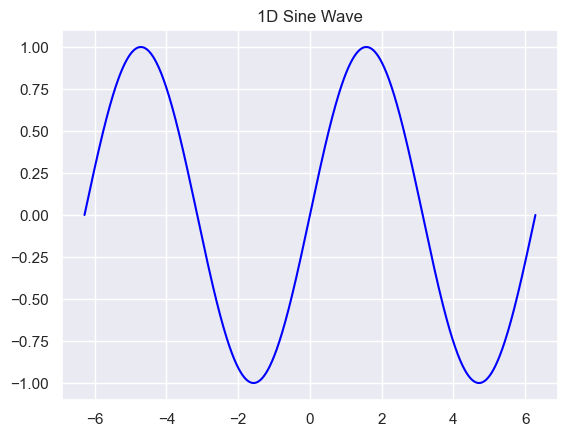

In [12]:
# Generate sine wave data
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000).unsqueeze(1)  # Increase dimension for batch processing
y = torch.sin(x)

plt.plot(x, y, color="blue")
plt.title("1D Sine Wave")
plt.show()

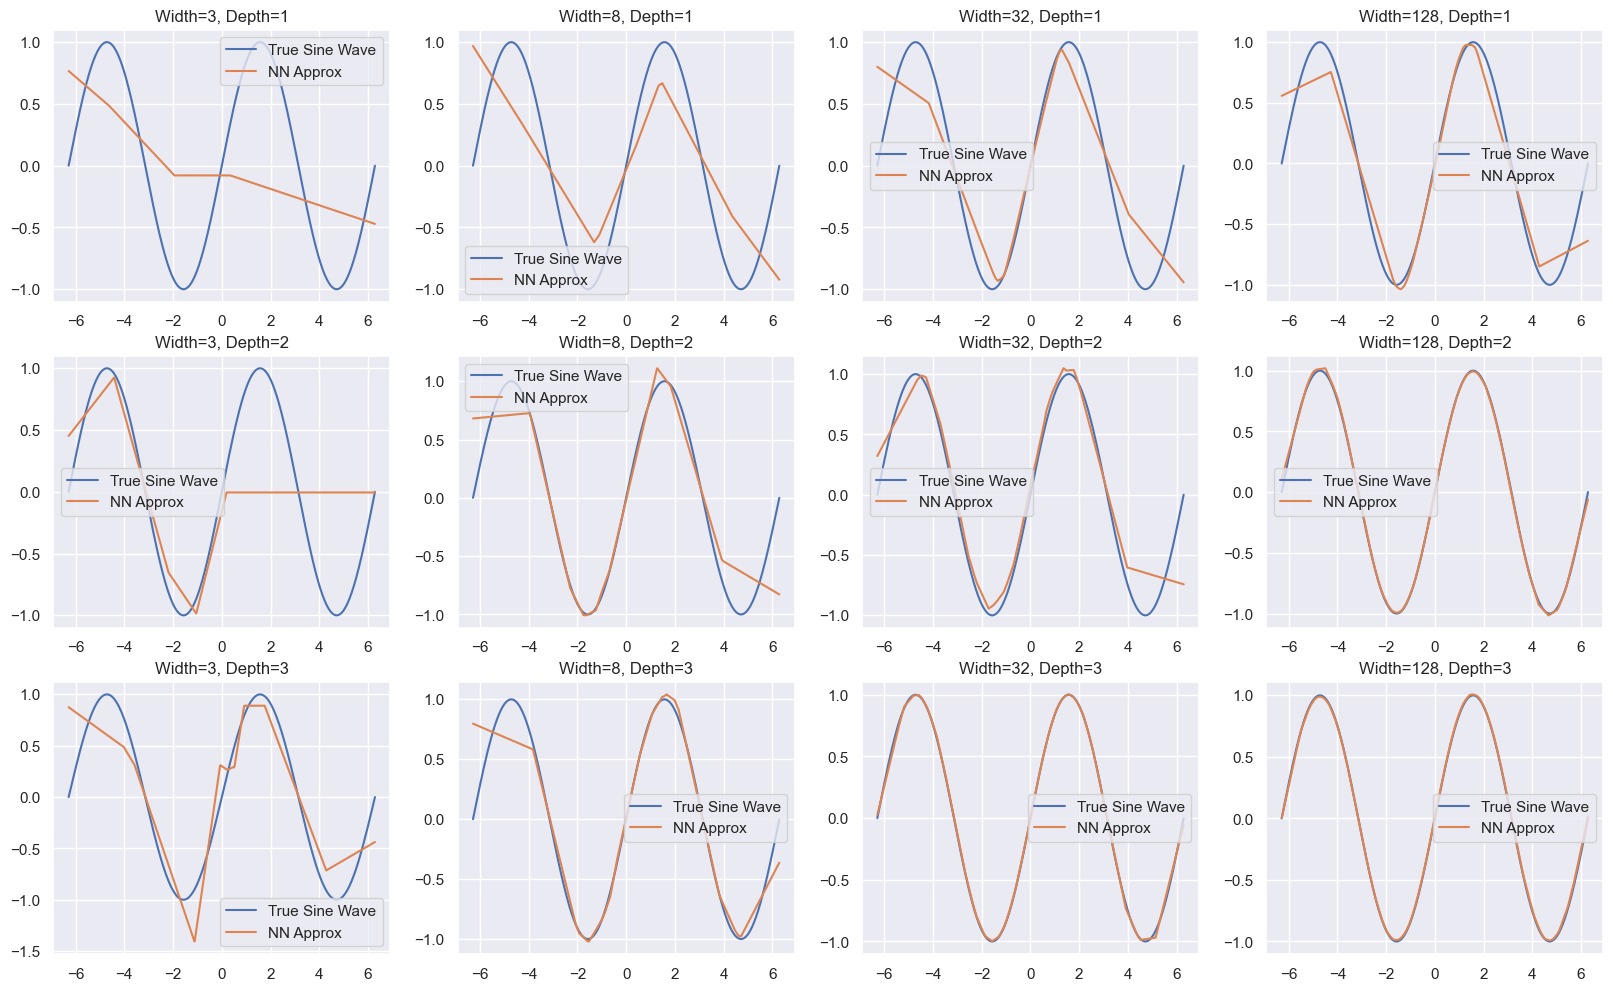

In [13]:
# Define activation function (without torch API)
act_fn = ReLU()

# Training parameters
learning_rate = 0.001
epochs = 100
batch_size = 64

# Loss function (without torch API)
criterion = MyMSELoss()

# Define the widths and depths to iterate over 
width_list = [3, 8, 32, 128]
depth_list = [1, 2, 3]

# Initialize the plot

fig, ax = plt.subplots(len(depth_list), len(width_list), figsize=(20, 12))
ax = ax.flatten()
plot_num = 0

# Train the model iteratively for different widths and depths
for depth in depth_list:
    for width in width_list:
        
        # Initialize the model
        hidden_sizes = [width] * depth
        model = MyFirstDenseNet(act_fn, input_size=1, output_size=1, hidden_sizes=hidden_sizes)

        # Initialize the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train the model
        for epoch in range(epochs):

            # Shuffle the data
            permutation = torch.randperm(x.size()[0])
            for i in range(0, x.size()[0], batch_size):

                # Get mini-batch
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x[indices], y[indices]

                # Set gradients to zero
                optimizer.zero_grad()

                # Forward pass
                outputs = model(batch_x)

                # Calculate loss
                loss = criterion(outputs, batch_y)

                # Backward pass
                loss.backward()

                # Update weights
                optimizer.step()
        
        # Plotting
        model.eval()
        with torch.no_grad():
            predicted = model(x)
            ax[plot_num].plot(x.numpy(), y.numpy(), label='True Sine Wave')
            ax[plot_num].plot(x.numpy(), predicted.numpy(), label=f'NN Approx')
            ax[plot_num].set_title(f'Width={width}, Depth={depth}')
            ax[plot_num].legend()

        plot_num += 1

plt.show()


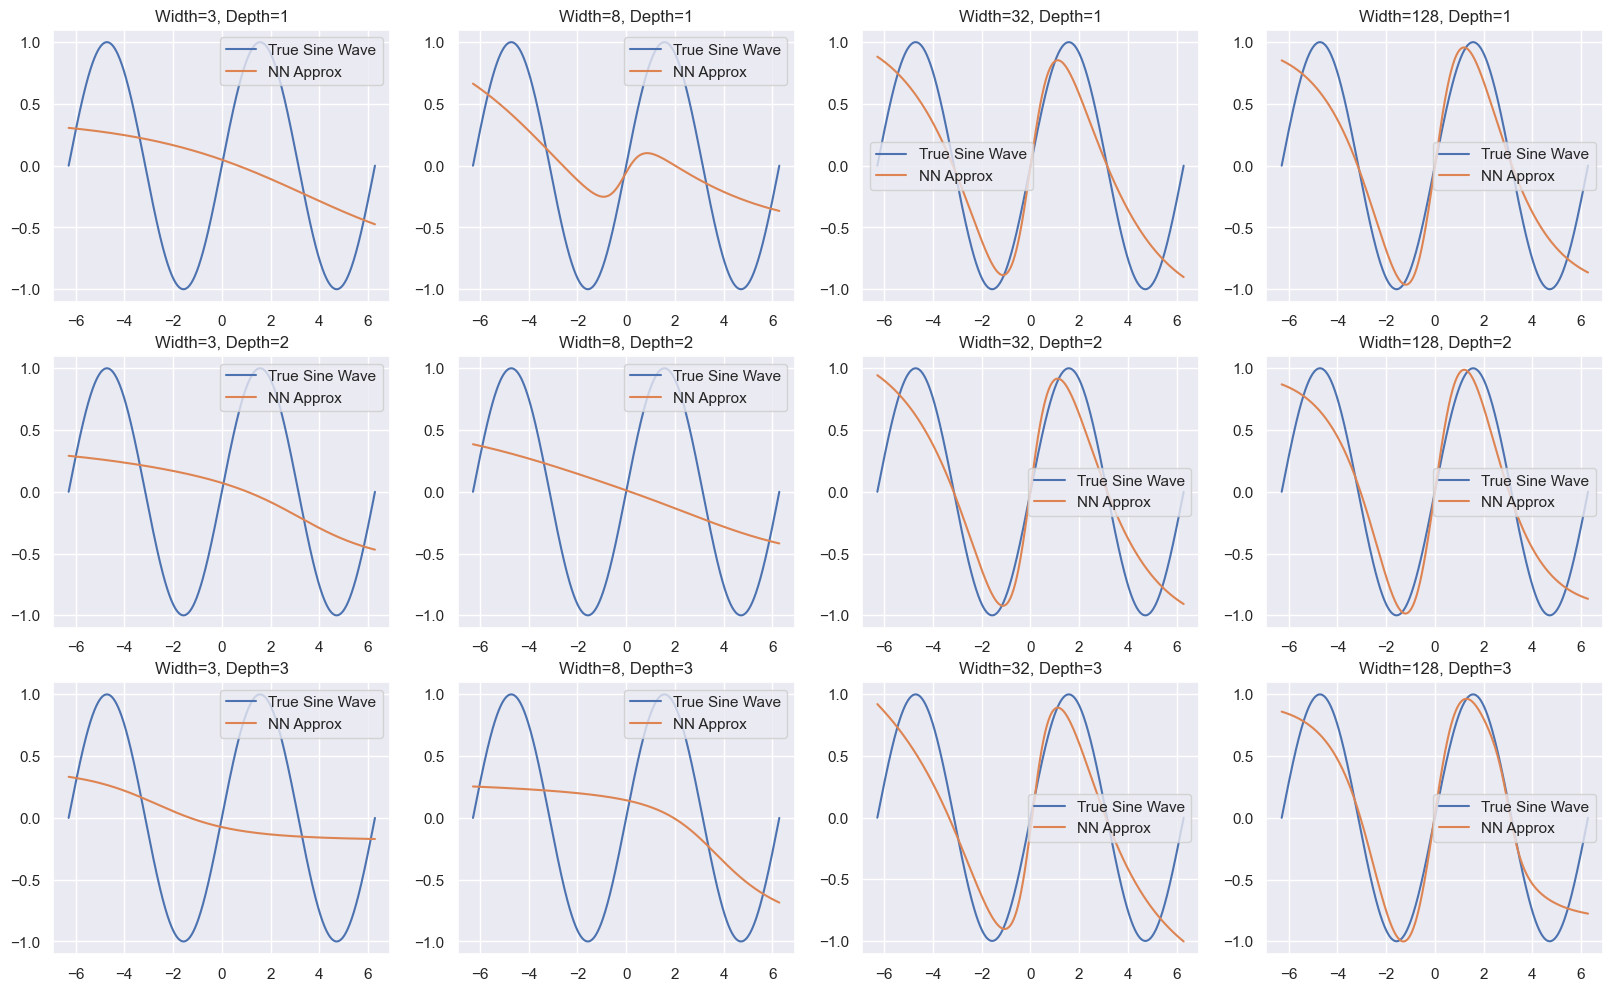

In [14]:
# Define activation function (without torch API)
act_fn = Sigmoid()

# Training parameters
learning_rate = 0.001
epochs = 100
batch_size = 64

# Loss function (without torch API)
criterion = MyMSELoss()

# Define the widths and depths to iterate over 
width_list = [3, 8, 32, 128]
depth_list = [1, 2, 3]

# Initialize the plot

fig, ax = plt.subplots(len(depth_list), len(width_list), figsize=(20, 12))
ax = ax.flatten()
plot_num = 0

# Train the model iteratively for different widths and depths
for depth in depth_list:
    for width in width_list:
        
        # Initialize the model
        hidden_sizes = [width] * depth
        model = MyFirstDenseNet(act_fn, input_size=1, output_size=1, hidden_sizes=hidden_sizes)

        # Initialize the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train the model
        for epoch in range(epochs):

            # Shuffle the data
            permutation = torch.randperm(x.size()[0])
            for i in range(0, x.size()[0], batch_size):

                # Get mini-batch
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x[indices], y[indices]

                # Set gradients to zero
                optimizer.zero_grad()

                # Forward pass
                outputs = model(batch_x)

                # Calculate loss
                loss = criterion(outputs, batch_y)

                # Backward pass
                loss.backward()

                # Update weights
                optimizer.step()
        
        # Plotting
        model.eval()
        with torch.no_grad():
            predicted = model(x)
            ax[plot_num].plot(x.numpy(), y.numpy(), label='True Sine Wave')
            ax[plot_num].plot(x.numpy(), predicted.numpy(), label=f'NN Approx')
            ax[plot_num].set_title(f'Width={width}, Depth={depth}')
            ax[plot_num].legend()

        plot_num += 1

plt.show()


In [ ]:
# Define activation function (without torch API)
act_fn = Tanh()

# Training parameters
learning_rate = 0.001
epochs = 100
batch_size = 64

# Loss function (without torch API)
criterion = MyMSELoss()

# Define the widths and depths to iterate over 
width_list = [3, 8, 32, 128]
depth_list = [1, 2, 3]

# Initialize the plot

fig, ax = plt.subplots(len(depth_list), len(width_list), figsize=(20, 12))
ax = ax.flatten()
plot_num = 0

# Train the model iteratively for different widths and depths
for depth in depth_list:
    for width in width_list:
        
        # Initialize the model
        hidden_sizes = [width] * depth
        model = MyFirstDenseNet(act_fn, input_size=1, output_size=1, hidden_sizes=hidden_sizes)

        # Initialize the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train the model
        for epoch in range(epochs):

            # Shuffle the data
            permutation = torch.randperm(x.size()[0])
            for i in range(0, x.size()[0], batch_size):

                # Get mini-batch
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x[indices], y[indices]

                # Set gradients to zero
                optimizer.zero_grad()

                # Forward pass
                outputs = model(batch_x)

                # Calculate loss
                loss = criterion(outputs, batch_y)

                # Backward pass
                loss.backward()

                # Update weights
                optimizer.step()
        
        # Plotting
        model.eval()
        with torch.no_grad():
            predicted = model(x)
            ax[plot_num].plot(x.numpy(), y.numpy(), label='True Sine Wave')
            ax[plot_num].plot(x.numpy(), predicted.numpy(), label=f'NN Approx')
            ax[plot_num].set_title(f'Width={width}, Depth={depth}')
            ax[plot_num].legend()

        plot_num += 1

plt.show()


### Building a torch network using torch.API (except for activation functions) and nn.Sequential


Now we are going to explore another method to define a Neural Network in PyTorch. Here we are going to make use of the PyTorch API with the exception for the activation function.

In [ ]:
class BaseNetwork(nn.Module):

    """There are many different ways to define a network in PyTorch. This is one of them. We use the nn.Sequential"""
    

    def __init__(self, act_fn, input_size=784, output_size=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            output_size - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Initialize the layers list as empty
        layers = []

        # Add input layer and activation function to layers list
        layers += [nn.Linear(input_size, hidden_sizes[0]), act_fn]

        # Add hidden layers to layers list and activation function after each layer
        for layer_index in range(1, len(hidden_sizes)):
            layers += [nn.Linear(hidden_sizes[layer_index-1], hidden_sizes[layer_index]), act_fn]
        
        # Add output layer to layers list (no activation function after output layer)
        layers += [nn.Linear(hidden_sizes[-1], output_size)]
        
        # Create the network as a sequence of layers
        # EXERCISE: What does the * do in front of layers?
        self.layers = nn.Sequential(*layers)

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "output_size": output_size, "hidden_sizes": hidden_sizes}

    def forward(self, x):

        # Flatten the input
        x = x.view(x.size(0), -1)

        # Pass the input through the layers
        out = self.layers(x)

        return out

## Analysing the effect of activation functions
***

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode.

To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images:

In [ ]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs, labels

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

In [ ]:
## Create a plot for every activation function
for i, act_fn_name in enumerate(activation_by_name):

    # Setting the seed ensures that we have the same weight initialization for each activation function
    torch.manual_seed(42) 

    # Initialize activation function and network
    act_fn = activation_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)

    # Visualize gradients
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup. All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the initialization of the weight parameters can be crucial. By default, PyTorch uses the Kaiming initialization for linear layers optimized for ReLU activations. 

### Training a model 
***

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice. Therefore, we write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [ ]:
def train_model(net, max_epochs=50, patience=7, batch_size=256):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """

    # Defining optimizer, loss and data loader
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
    loss_module = nn.CrossEntropyLoss()
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

    # Lists for storing the validation accuracy and the best epoch
    val_scores = []
    best_val_epoch = -1
    best_model_params = None

    for epoch in range(max_epochs):

        # Training 
        net.train()

        true_preds, count = 0., 0
        for imgs, labels in train_loader_local:
            
            # Set gradients to zero
            optimizer.zero_grad() 

            # Forward pass
            preds = net(imgs)

            # Calculate loss
            loss = loss_module(preds, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]

        # Calculate training accuracy
        train_acc = true_preds / count

        # Validation 
        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)

        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            best_model_params = net.state_dict()
            best_val_epoch = epoch

        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping due to no improvement over the last {patience} epochs")
            break

    # Plot a curve of the validation accuracy
    plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title(f"Validation performance")
    plt.show()
    plt.close()

    # Loading the best model parameters
    net.load_state_dict(best_model_params)
    
    # Compute accuracy on the test set
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [ ]:
models_dict = {act_name : BaseNetwork(act_fn=act_fn()) for act_name, act_fn in activation_by_name.items()}

for activation, model in models_dict.items():

    # Verbose
    print('='*100)
    print(f"Training BaseNetwork with {activation} activation...", '\n')

    # Set seed for reproducibility
    torch.manual_seed(42)

    # Train the model
    train_model(model)

Not surprisingly, the model using the sigmoid activation function shows to fail and does not improve upon random performance (10 classes => 1/10 for random chance).

All the other activation functions gain similar performance. To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages. However, the “optimal” activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc.) so that a thorough grid search would not be useful in our case. In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions we experiment with here, with small gains for specific activation functions in specific networks.

### Visualizing the activation distribution

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [ ]:
def visualize_activations(net, color="C0"):

    activations = {}

    net.eval()

    small_loader = data.DataLoader(train_set, batch_size=1024)

    imgs, labels = next(iter(small_loader))

    with torch.no_grad():

        layer_index = 0
        imgs = imgs.view(imgs.size(0), -1)
        
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

for i, act_fn_name in enumerate(activation_by_name):
    
    visualize_activations(models_dict[act_fn_name], color=f"C{i}")

As the model with sigmoid activation was not able to train properly, the activations are also less informative and all gathered around 0.5 (the activation at input 0).

The tanh shows a more diverse behavior. While for the input layer we experience a larger amount of neurons to be close to -1 and 1, where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).

The ReLU has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values. The LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution. The Swish activation seems to lie in between, although it is worth noting that Swish uses significantly higher values than other activation functions (up to 20).

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the “optimal” activation function really depends on many factors, and is not the same for all possible networks.

### EXERCISE
Duplicate this notebook twice. In the first duplicate add dropout using `torch.nn.Dropout(0.2)` after each activation.
In the second duplicate use nn.BatchNorm1d before the first two activation functions (or if it is a depth-1 network only after the first linear layer). Compare the distributions of the activations in this three settings. 

Recall that at initialisation, dropout takes as input the percentage of the number of outputs we want to drop (i.e. 0.2). As for batch norm, it takes as input the dimension of pre-activation vectors. 

As mentioned in the tutorial, these layers are active only in the training phase. Therefore, if you run the duplicates of this file you won't see the effect of these layers in the plots. Hence, you should first re run the file as it is and see if you can spot any differences. **AFTERWARDS, YOU HAVE TO CHANGE THE VISUALIZE_ACTIVATIONS FUNCTIONS BY CHANGING `net.eval()` to `net.train()`.**